# Introduction
In this notebook, we will try a number of methods to create a digit recognizer that is able to classify gray-scale images of handwritten numbers ranging from 0 to 9.

We will attempt to use a deep neural network, a a Convolutional Neural Network(CNN), as well as Transfer Learning.

If you are new to deep learning or computer vision, I highly recommend the free courses available on Kaggle: https://www.kaggle.com/learn

Let's get started!

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
sns.set()

train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Description
From the competition page:

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
```

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

If we re-shape a row of the data into a 28 x 28 matrix, we can see the original image:

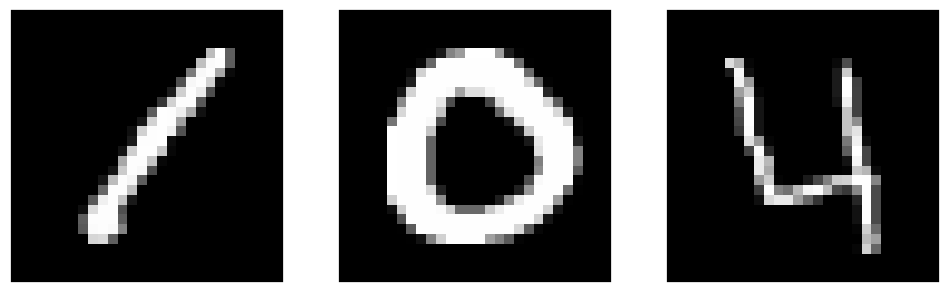

In [2]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)
axes[0].imshow(train.drop(columns=['label']).iloc[0].values.reshape(28, 28, 1), cmap='gray')
axes[1].imshow(train.drop(columns=['label']).iloc[4].values.reshape(28, 28, 1), cmap='gray')
axes[2].imshow(train.drop(columns=['label']).iloc[3].values.reshape(28, 28, 1), cmap='gray')
axes[0].set_xticks([])
axes[0].set_yticks([])

plt.show()

This is also how we will input the data into the model, so let's remove the label and re-shape our train and test data now.

In [3]:
# One-hot encode labels
train_y = to_categorical(train['label'].copy(), num_classes=10)

train_X = train.drop(columns=['label']).values.reshape(train.shape[0], 28, 28, 1)
test = test.values.reshape(test.shape[0], 28, 28, 1)

Before proceeding, we should confirm if there is any class imbalance in our data.

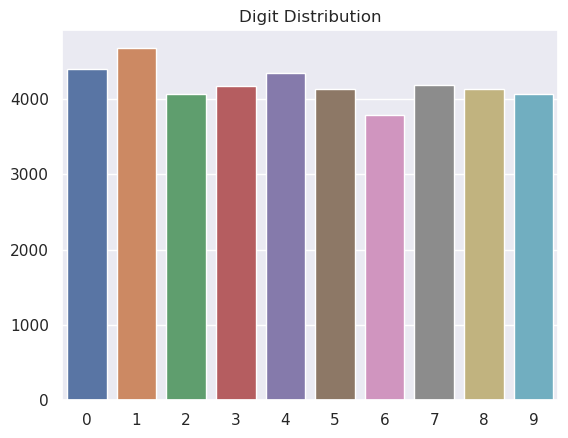

In [4]:
ax = sns.barplot(x=train['label'].unique(), y=train['label'].value_counts())
ax.set_ylabel('')
ax.set_title('Digit Distribution')

plt.show()

There doesn't seem to be any significant imbalance, so let's proceed.

# Preprocessing

## Normalization
Data normalization scales input features to a consistent range, which helps deep neural networks have faster and more stable convergence during training by ensuring that all features have similar magnitudes and distributions. This reduces the chances of certain weights updating faster than others, leading to a smoother and more efficient optimization landscape.

Grayscale normalization is a preprocessing technique for grayscale images where pixel values, typically ranging from 0 to 255, are scaled to fall within the range of 0 to 1. This is achieved by dividing each pixel value by 255, helping improve the convergence speed and performance of neural networks.

Let's apply grayscale normalization to our data now.

In [5]:
train_X = train_X / 255
test = test / 255
train_X[4][5]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.03137255],
       [0.40392157],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.44705882],
       [0.00784314],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

## Data Augmentation
Data Augmentation is the process of generating additional training data based on the data we already have in order to help models generalize better. For images, this is mainly done by flipping, shifting, rotating, zooming the images, as well as other transformations. 

A key point to remember when augmenting data is that we want to preserve the classes. If we were to vertically and horizontally flip 6 for example, it would now be 9, and we would have confused the classes in our training data.

For our data, let's add zoom, rotation, as well as vertical and horizontal shifts.

In [6]:
image_gen = ImageDataGenerator(
                              zoom_range=0.1,
                              rotation_range=10,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=False,
                              vertical_flip=False,
                              validation_split=0.2 # 80/20 train/val split
                              ) 

train_generator = image_gen.flow(
                                train_X, 
                                train_y,
                                batch_size=32,
                                shuffle=True,
                                subset='training'
                                )

valid_generator = image_gen.flow(
                                train_X,
                                train_y,
                                batch_size=32,
                                shuffle=True,
                                subset='validation'
                                )

# Model Creation & Comparison

## Deep Neural Network
Now let's create a simple deep neural network with dropout and batch normalization layers as a baseline. We'll include an early stopping callback as well.

In [7]:
model1 = keras.Sequential()

# Hidden ReLU layers w/ dropout and batch normalization
model1.add(layers.Dense(units=32, activation='relu', input_shape=[28, 28, 1]))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.3))
    
model1.add(layers.Dense(units=64, activation='relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.3))
    
model1.add(layers.Dense(units=128, activation='relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.3))
    
# Layer to convert outputs to 1D vector
model1.add(layers.Flatten())
    
# Layer to extract high-level features from 1D vector
model1.add(layers.Dense(units=128, activation="relu"))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.5))
    
# Class probabilities output layer
model1.add(layers.Dense(units=10, activation='softmax'))

In [8]:
%%time
# Early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True
                                        )

# Annealer callback to exponentially decay learning rate each epoch
annealer = callbacks.LearningRateScheduler(lambda x: .01 * 0.9 ** x)

def compile_fit(model):
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
                 )

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=150,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_steps=valid_generator.n // valid_generator.batch_size,
        callbacks=[early_stopping, annealer],
        verbose=0
                       )
    
    return history
    
history1 = compile_fit(model1)

CPU times: user 12min 41s, sys: 32.7 s, total: 13min 14s
Wall time: 10min 41s


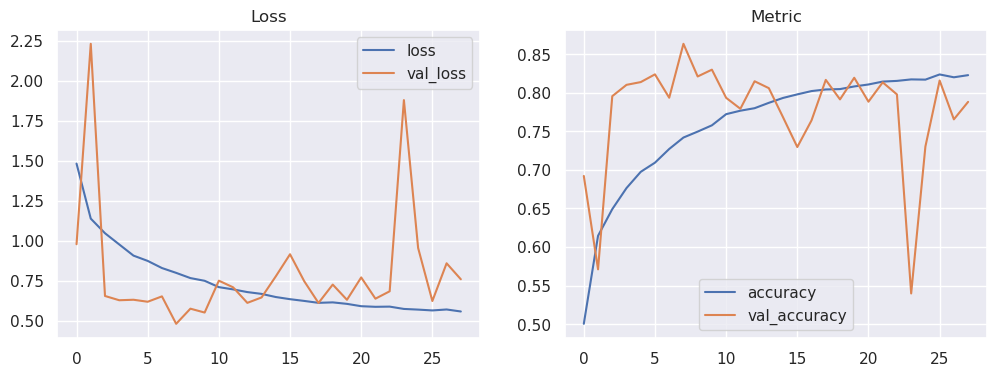

In [9]:
def history_plot(history):
    history_frame = pd.DataFrame(history.history)
    fig, ax = plt.subplots(ncols=2, figsize=(12,4))
    history_frame.loc[:, ['loss', 'val_loss']].plot(title='Loss', ax=ax[0])
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(title='Metric', ax=ax[1])
    
history_plot(history1)

It looks like our model is not generalizing well. Let's try a different approach.

## CNN
Now let's see how a CNN will perform compared to our DNN. CNNs are deep neural networks that excel at image classification, through the use of a special architecture known as convolutional blocks. A single pass through a convolutional block filters, detects, and condenses simple features like lines and contrasts. As the inputs are passed through more convolutional blocks, the features they output become increasingly complex.

In [10]:
model2 = keras.Sequential()

# First convolutional block
model2.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[28, 28, 1]))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D())
model2.add(layers.Dropout(0.3))

# Second convolutional block
model2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D())
model2.add(layers.Dropout(0.3))

# Third convolutional block
model2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPool2D())
model2.add(layers.Dropout(0.3))

# Classifier head
model2.add(layers.Flatten())
model2.add(layers.Dense(units=128, activation="relu"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(units=10, activation="softmax"))

CPU times: user 29min 13s, sys: 58 s, total: 30min 11s
Wall time: 23min 36s


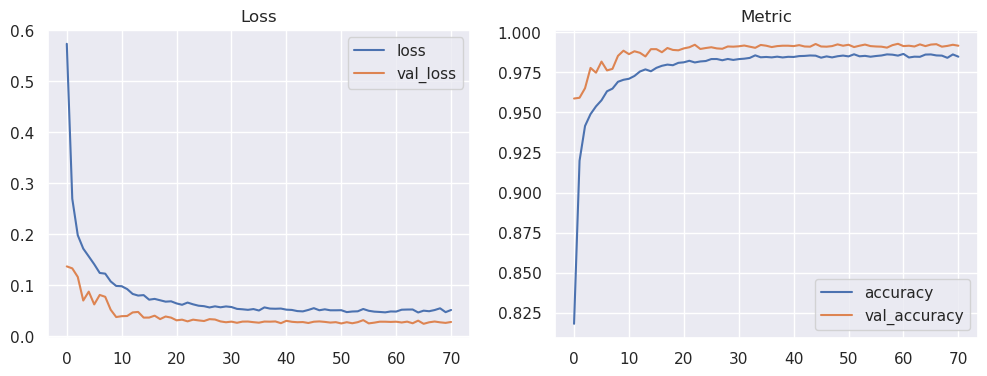

In [11]:
%%time
history2 = compile_fit(model2)
history_plot(history2)

What a huge improvement! It looks like we are at around 98% accuracy!

## Transfer Learning
In practice it is rare to create CNNs from scratch. It is more common to use the base of a pre-trained model, which excels at feature extraction, and then attach an untrained classifier head to it. This is known as transfer learning.

VGG (Visual Geometry Group) is a convolutional neural network (CNN) architecture that was introduced by the Visual Geometry Group at the University of Oxford. It is known for its simplicity and effectiveness in image classification tasks. VGG was a runner-up in the ILSVRC (ImageNet Large Scale Visual Recognition Challenge) 2014, which led to its popularity and widespread use.

Let's use VGG16 as a base for our CNN and see how this affects performance.

In [12]:
# Convert from grayscale to rgb since ResNet50 uses 3 channels
train_X_rgb = tf.image.grayscale_to_rgb(tf.constant(train_X))

# Re-size since ResNet50 needs larger image size
train_X_large = tf.image.resize(train_X_rgb, [85, 85], method='nearest')

train_generator = image_gen.flow(
                                train_X_large, 
                                train_y,
                                batch_size=32,
                                shuffle=True,
                                subset='training'
                                )

valid_generator = image_gen.flow(
                                train_X_large,
                                train_y,
                                batch_size=32,
                                shuffle=True,
                                subset='validation'
                                )

In [13]:
model3 = keras.Sequential()

# Pre-trained base
base_model = keras.applications.vgg16.VGG16(input_shape=(85, 85, 3), 
                                               include_top=False,
                                               # Load pre-trained weights
                                               weights='imagenet',
                                               pooling='avg')

# Prevent training of the base model since it is already trained
base_model.trainable = False
model3.add(base_model)

# Classifier head
model3.add(layers.Flatten())
model3.add(layers.Dense(units=128, activation="relu"))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(units=10, activation="softmax"))

58889256/58889256 [==============================] - 0s 0us/step


CPU times: user 1h 39min 53s, sys: 1min 13s, total: 1h 41min 6s
Wall time: 1h 53min 48s


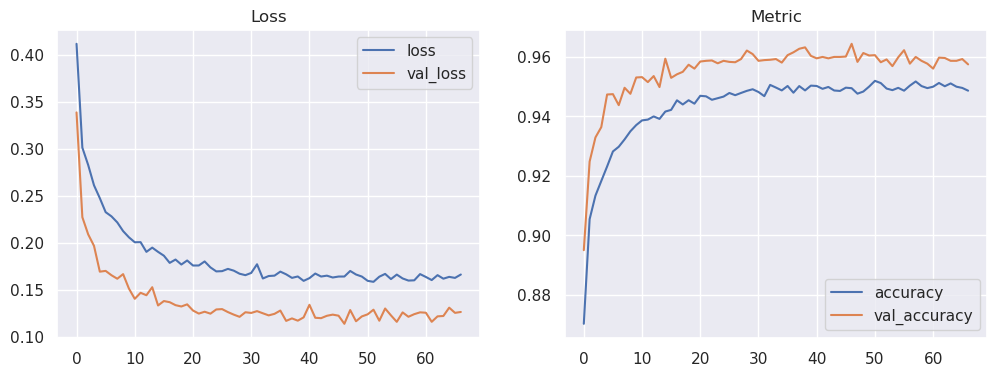

In [14]:
%%time
history3 = compile_fit(model3)
history_plot(history3)

Not bad! 

The VGG16 architecture was originally trained on images of size 224x224 pixels, which means that when you use a pre-trained VGG16 model or implement a similar architecture from scratch, you should resize your input images to the dimensions that the model expects, which is typically 224x224 pixels. Due to RAM limitations this wasn't possible here, but we were at least able to see how transfer learning works.

# Submission

In [15]:
def create_submission(model):
    predictions = model.predict(test)
    # Select the index(label) with the highest probability
    final_predictions = np.argmax(predictions, axis=1)
    submission_df = pd.DataFrame({'ImageId': list(range(1,len(final_predictions)+1)), 
                                  'Label': final_predictions})
    submission_df.to_csv('submission.csv', index=False)
    
create_submission(model2)

875/875 [==============================] - 2s 2ms/step
